In [1]:
from __future__ import absolute_import, division, print_function

import argparse
import csv
import logging
import os
import random
import sys
import itertools

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from torch.nn import CrossEntropyLoss, MSELoss
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import matthews_corrcoef, f1_score

from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE, WEIGHTS_NAME, CONFIG_NAME
from pytorch_pretrained_bert.modeling import BertConfig

# from pytorch_pretrained_bert.modeling import BertForSequenceClassification
from modeling import BertForSequenceClassification_Quant as BertForSequenceClassification

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

FORMAT = '[%(asctime)-15s %(filename)s:%(lineno)s] %(message)s'
FORMAT_MINIMAL = '%(message)s'

logging.basicConfig(format=FORMAT)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [2]:
from run_classifier import *
from FIT_utils import *
import matplotlib.pyplot as plt
from quant_modules import QuantLinear, QuantLinear_Act, QuantEmbedding

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
args = type('MyClass', (object,), {'content':{}})()
args.data_dir = '/home/ben/Documents/CERN/rebuttal_iclr/GLUE/SST-2/'
args.bert_model = 'bert-base-uncased'
args.do_lower_case = True
args.train_batch_size = 32
args.max_seq_length = 128
args.task_name = 'SST-2'
args.cache_dir = None
args.config = None
args.config_dir = None
args.local_rank=-1
args.bit_options = [2,3,4,8,32]
args.load_directory = '/home/ben/Documents/CERN/rebuttal_iclr/sst_pretrained/'

In [5]:
processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor,
    "wnli": WnliProcessor,
}

output_modes = {
    "cola": "classification",
    "mnli": "classification",
    "mrpc": "classification",
    "sst-2": "classification",
    "sts-b": "regression",
    "qqp": "classification",
    "qnli": "classification",
    "rte": "classification",
    "wnli": "classification",
}

In [6]:
task_name = args.task_name.lower()

In [7]:
processor = processors[task_name]()
output_mode = output_modes[task_name]

label_list = processor.get_labels()
num_labels = len(label_list)

In [8]:
model = BertForSequenceClassification.from_pretrained(
            args.load_directory, num_labels=num_labels, config=args.config)
tokenizer = BertTokenizer.from_pretrained(
    args.load_directory, do_lower_case=args.do_lower_case)

[2023-01-21 19:46:35,218 modeling.py:370] loading archive file /home/ben/Documents/CERN/rebuttal_iclr/sst_pretrained/


In [9]:
# tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)

In [10]:
# model = BertForSequenceClassification.from_pretrained(
#         args.bert_model,
#         cache_dir=cache_dir,
#         num_labels=num_labels,
#         config_dir=args.config_dir,
#         config=args.config)

In [9]:
train_examples = processor.get_train_examples(args.data_dir)

In [10]:
cache_dir = args.cache_dir if args.cache_dir else os.path.join(
        str(PYTORCH_PRETRAINED_BERT_CACHE), 'distributed_{}'.format(
            args.local_rank))

In [11]:
model.to(device)

BertForSequenceClassification_Quant(
  (bert): BertModel_Quant(
    (embeddings): BertEmbeddings_Quant(
      (word_embeddings): QuantEmbedding(30522, 768, padding_idx=0)
      (position_embeddings): QuantEmbedding(512, 768)
      (token_type_embeddings): QuantEmbedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder_Quant(
      (layer): ModuleList(
        (0): BertLayer_Quant(
          (attention): BertAttention_Quant(
            (self): BertSelfAttention_Quant(
              (query): QuantLinear(in_features=768, out_features=768, bias=True)
              (key): QuantLinear(in_features=768, out_features=768, bias=True)
              (value): QuantLinear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput_Quant(
              (dense): QuantLinear(in_features=768, out_features=768, bias=True)
              (Lay

In [12]:
train_features = convert_examples_to_features(
    train_examples, label_list, args.max_seq_length, tokenizer,
    output_mode)
all_input_ids = torch.tensor([f.input_ids for f in train_features],
                             dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features],
                              dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features],
                               dtype=torch.long)

if output_mode == "classification":
    all_label_ids = torch.tensor([f.label_id for f in train_features],
                                 dtype=torch.long)
elif output_mode == "regression":
    all_label_ids = torch.tensor([f.label_id for f in train_features],
                                 dtype=torch.float)

train_data = TensorDataset(all_input_ids, all_input_mask,
                           all_segment_ids, all_label_ids)
if args.local_rank == -1:
    train_sampler = RandomSampler(train_data)
else:
    train_sampler = DistributedSampler(train_data)
train_dataloader = DataLoader(
    train_data,
    sampler=train_sampler,
    batch_size=args.train_batch_size)

[2023-01-21 19:47:18,722 run_classifier.py:431] Writing example 0 of 67349
[2023-01-21 19:47:18,723 run_classifier.py:496] *** Example ***
[2023-01-21 19:47:18,723 run_classifier.py:497] guid: train-1
[2023-01-21 19:47:18,724 run_classifier.py:498] tokens: [CLS] hide new secret ##ions from the parental units [SEP]
[2023-01-21 19:47:18,724 run_classifier.py:499] input_ids: 101 5342 2047 3595 8496 2013 1996 18643 3197 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[2023-01-21 19:47:18,725 run_classifier.py:501] input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[2023-01-21 19:47:18,725

In [13]:
model.eval()

BertForSequenceClassification_Quant(
  (bert): BertModel_Quant(
    (embeddings): BertEmbeddings_Quant(
      (word_embeddings): QuantEmbedding(30522, 768, padding_idx=0)
      (position_embeddings): QuantEmbedding(512, 768)
      (token_type_embeddings): QuantEmbedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder_Quant(
      (layer): ModuleList(
        (0): BertLayer_Quant(
          (attention): BertAttention_Quant(
            (self): BertSelfAttention_Quant(
              (query): QuantLinear(in_features=768, out_features=768, bias=True)
              (key): QuantLinear(in_features=768, out_features=768, bias=True)
              (value): QuantLinear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput_Quant(
              (dense): QuantLinear(in_features=768, out_features=768, bias=True)
              (Lay

In [14]:
fit_computerw = FIT(model, device, train_dataloader, ['pooler', 'classifier'])

72
84934656
0 bert.encoder.layer.0.attention.self.query 589824
1 bert.encoder.layer.0.attention.self.key 589824
2 bert.encoder.layer.0.attention.self.value 589824
3 bert.encoder.layer.0.attention.output.dense 589824
4 bert.encoder.layer.0.intermediate.dense 2359296
5 bert.encoder.layer.0.output.dense 2359296
6 bert.encoder.layer.1.attention.self.query 589824
7 bert.encoder.layer.1.attention.self.key 589824
8 bert.encoder.layer.1.attention.self.value 589824
9 bert.encoder.layer.1.attention.output.dense 589824
10 bert.encoder.layer.1.intermediate.dense 2359296
11 bert.encoder.layer.1.output.dense 2359296
12 bert.encoder.layer.2.attention.self.query 589824
13 bert.encoder.layer.2.attention.self.key 589824
14 bert.encoder.layer.2.attention.self.value 589824
15 bert.encoder.layer.2.attention.output.dense 589824
16 bert.encoder.layer.2.intermediate.dense 2359296
17 bert.encoder.layer.2.output.dense 2359296
18 bert.encoder.layer.3.attention.self.query 589824
19 bert.encoder.layer.3.attention.

In [15]:
criterion = CrossEntropyLoss()
EFw, EFa, fap, faa, param_ranges, act_ranges = fit_computerw.EF(model, train_dataloader, 
                                                               criterion, 
                                                               tol=1e-2, 
                                                               min_iterations=50,
                                                               max_iterations=200,
                                                               num_labels = num_labels)

Iteration 2.0, Estimator variance: W:0.15215131640434265 / A:0.08213309198617935
Iteration 3.0, Estimator variance: W:0.6260999043782552 / A:0.6263341903686523
Iteration 4.0, Estimator variance: W:0.25918495655059814 / A:0.2668119966983795
Iteration 5.0, Estimator variance: W:0.259454083442688 / A:0.25673234462738037
Iteration 6.0, Estimator variance: W:0.29247917731602985 / A:0.2897574504216512
Iteration 7.0, Estimator variance: W:0.315678528376988 / A:0.31300204140799387
Iteration 8.0, Estimator variance: W:0.31597843766212463 / A:0.3135317862033844
Iteration 9.0, Estimator variance: W:0.32847340901692706 / A:0.3259550200568305
Iteration 10.0, Estimator variance: W:0.33639326095581057 / A:0.33373949527740476
Iteration 11.0, Estimator variance: W:0.23874035748568448 / A:0.21431472084738992
Iteration 12.0, Estimator variance: W:0.20368041594823202 / A:0.16696540514628092
Iteration 13.0, Estimator variance: W:0.1828754498408391 / A:0.1487034375850971
Iteration 14.0, Estimator variance: 

Iteration 102.0, Estimator variance: W:0.0316239268172021 / A:0.028040888262730018
Iteration 103.0, Estimator variance: W:0.03167522532268635 / A:0.028096900402920916
Iteration 104.0, Estimator variance: W:0.030717762616964486 / A:0.02702577756001399
Iteration 105.0, Estimator variance: W:0.029584582646687826 / A:0.026111888885498046
Iteration 106.0, Estimator variance: W:0.028554680212488713 / A:0.025058494423920254
Iteration 107.0, Estimator variance: W:0.028606528433683876 / A:0.02512265142993392
Iteration 108.0, Estimator variance: W:0.027772720213289612 / A:0.024510416719648574
Iteration 109.0, Estimator variance: W:0.0277159629611794 / A:0.024488516903798514
Iteration 110.0, Estimator variance: W:0.02694650129838423 / A:0.023906350135803223
Iteration 111.0, Estimator variance: W:0.02590183094815091 / A:0.023006026809279982
Iteration 112.0, Estimator variance: W:0.025459080934524536 / A:0.022631717579705373
Iteration 113.0, Estimator variance: W:0.02553229627356065 / A:0.022706413

Iteration 199.0, Estimator variance: W:0.013676935703910176 / A:0.012001799578642725
Iteration 200.0, Estimator variance: W:0.013651937246322632 / A:0.01198022961616516


In [18]:
model = BertForSequenceClassification.from_pretrained(
            args.load_directory, num_labels=num_labels, config=args.config)
model.to(device)
model.eval()

[2022-11-16 13:33:17,987 modeling.py:370] loading archive file /home/ben/Documents/CERN/rebuttal_iclr/sst_pretrained/


BertForSequenceClassification_Quant(
  (bert): BertModel_Quant(
    (embeddings): BertEmbeddings_Quant(
      (word_embeddings): QuantEmbedding(30522, 768, padding_idx=0)
      (position_embeddings): QuantEmbedding(512, 768)
      (token_type_embeddings): QuantEmbedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder_Quant(
      (layer): ModuleList(
        (0): BertLayer_Quant(
          (attention): BertAttention_Quant(
            (self): BertSelfAttention_Quant(
              (query): QuantLinear(in_features=768, out_features=768, bias=True)
              (key): QuantLinear(in_features=768, out_features=768, bias=True)
              (value): QuantLinear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput_Quant(
              (dense): QuantLinear(in_features=768, out_features=768, bias=True)
              (Lay

In [19]:
fit_computera = FIT(model, device, train_dataloader, ['output', 'pooler', 'classifier'])

48
49545216
0 bert.encoder.layer.0.attention.self.query 589824
1 bert.encoder.layer.0.attention.self.key 589824
2 bert.encoder.layer.0.attention.self.value 589824
3 bert.encoder.layer.0.intermediate.dense 2359296
4 bert.encoder.layer.1.attention.self.query 589824
5 bert.encoder.layer.1.attention.self.key 589824
6 bert.encoder.layer.1.attention.self.value 589824
7 bert.encoder.layer.1.intermediate.dense 2359296
8 bert.encoder.layer.2.attention.self.query 589824
9 bert.encoder.layer.2.attention.self.key 589824
10 bert.encoder.layer.2.attention.self.value 589824
11 bert.encoder.layer.2.intermediate.dense 2359296
12 bert.encoder.layer.3.attention.self.query 589824
13 bert.encoder.layer.3.attention.self.key 589824
14 bert.encoder.layer.3.attention.self.value 589824
15 bert.encoder.layer.3.intermediate.dense 2359296
16 bert.encoder.layer.4.attention.self.query 589824
17 bert.encoder.layer.4.attention.self.key 589824
18 bert.encoder.layer.4.attention.self.value 589824
19 bert.encoder.layer.4.

In [20]:
_, EFa, _, faa, _, act_ranges = fit_computera.EF(model, train_dataloader, 
                                                               criterion, 
                                                               tol=1e-2, 
                                                               min_iterations=50,
                                                               max_iterations=200,
                                                               num_labels = num_labels)

Iteration 2.0, Estimator variance: W:0.48905685544013977 / A:0.4920063018798828
Iteration 3.0, Estimator variance: W:0.5610355933507284 / A:0.5763207276662191
Iteration 4.0, Estimator variance: W:0.25596365332603455 / A:0.2340482473373413
Iteration 5.0, Estimator variance: W:0.3051965951919556 / A:0.2836434841156006
Iteration 6.0, Estimator variance: W:0.33465683460235596 / A:0.31431762377421063
Iteration 7.0, Estimator variance: W:0.35742691584995817 / A:0.33740523883274626
Iteration 8.0, Estimator variance: W:0.2594064176082611 / A:0.2632390558719635
Iteration 9.0, Estimator variance: W:0.27033864127265084 / A:0.2738480303022597
Iteration 10.0, Estimator variance: W:0.2702185869216919 / A:0.273660683631897
Iteration 11.0, Estimator variance: W:0.1889463554729115 / A:0.19117732481522995
Iteration 12.0, Estimator variance: W:0.19299644231796265 / A:0.19654887914657593
Iteration 13.0, Estimator variance: W:0.19902748327988845 / A:0.20259736134455755
Iteration 14.0, Estimator variance: W

Iteration 104.0, Estimator variance: W:0.037798251097018905 / A:0.026980491784902718
Iteration 105.0, Estimator variance: W:0.037878615515572686 / A:0.02706628299894787
Iteration 106.0, Estimator variance: W:0.037959314742178285 / A:0.02715143842517205
Iteration 107.0, Estimator variance: W:0.036936831251483095 / A:0.026293915008830132
Iteration 108.0, Estimator variance: W:0.03701076242658827 / A:0.026374006712878192
Iteration 109.0, Estimator variance: W:0.03709208199737269 / A:0.026456436979661293
Iteration 110.0, Estimator variance: W:0.03710584207014604 / A:0.02648542360825972
Iteration 111.0, Estimator variance: W:0.03718255876420854 / A:0.02656319334700301
Iteration 112.0, Estimator variance: W:0.0370995146887643 / A:0.02653887016432626
Iteration 113.0, Estimator variance: W:0.03666670976486881 / A:0.026158001570575004
Iteration 114.0, Estimator variance: W:0.036205312661957326 / A:0.025896323354620682
Iteration 115.0, Estimator variance: W:0.036264983467433766 / A:0.02596045577

In [16]:
plt.style.use('/home/ben/Documents/CERN/Fisher_benchmarking/physics.mplstyle')

[2023-01-21 19:48:49,886 font_manager.py:1350] findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
[2023-01-21 19:48:49,887 font_manager.py:1355] findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
[2023-01-21 19:48:49,894 font_manager.py:1350] findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
[2023-01-21 19:48:49,894 font_manager.py:1355] findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


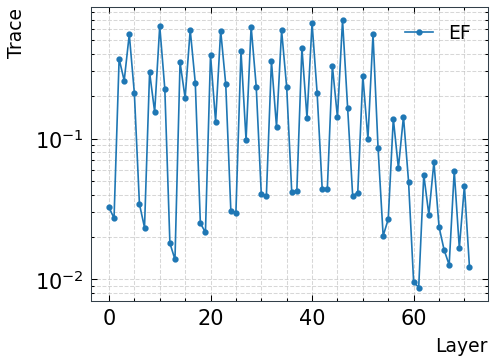

In [17]:
# plt.title('W Trace')
plt.plot(EFw,'o-', label='EF')
plt.grid(True, which='both')
plt.legend()
plt.yscale('log')
plt.xlabel('Layer', horizontalalignment='right', x=1.)
plt.ylabel('Trace', horizontalalignment='right', y=1.)
plt.tight_layout()
plt.savefig('/home/ben/Documents/CERN/rebuttal_iclr/bert_configs/tracew.pdf')

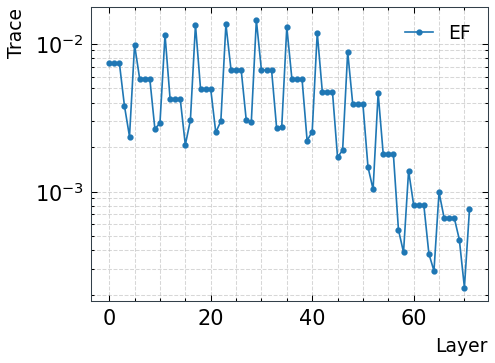

In [18]:
# plt.title('A Trace')
plt.plot(EFa,'o-', label='EF')
plt.grid(True, which='both')
plt.legend()
plt.yscale('log')
plt.xlabel('Layer', horizontalalignment='right', x=1.)
plt.ylabel('Trace', horizontalalignment='right', y=1.)
plt.tight_layout()
plt.savefig('/home/ben/Documents/CERN/rebuttal_iclr/bert_configs/tracea.pdf')

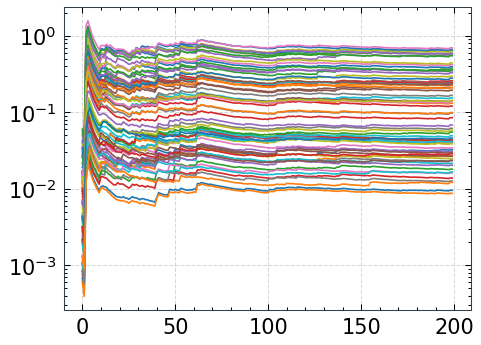

In [19]:
plt.plot(fap)
plt.yscale('log')

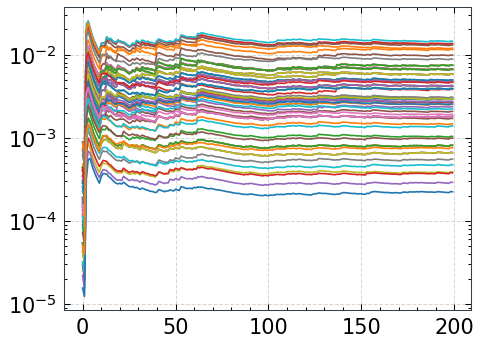

In [20]:
plt.plot(faa)
plt.yscale('log')

In [22]:
fit_computerw.Ra = act_ranges
fit_computerw.EFa = EFa

In [18]:
## Define useful layer hooks:
def linear_flops_counter_hook(module, input, output):
    input = input[0]
    # pytorch checks dimensions, so here we don't care much
    output_last_dim = output.shape[-1]
    bias_flops = output_last_dim if module.bias is not None else 0
    module.__flops__ += int(np.prod(input.shape) * output_last_dim + bias_flops)

In [19]:
MODULES_MAPPING = {
    nn.Linear: linear_flops_counter_hook,
    QuantLinear: linear_flops_counter_hook,
}

In [20]:
def bert_input_constructor(input_shape, tokenizer):
    inp_seq = ""
    for _ in range(input_shape[1] - 2):  # there are two special tokens [CLS] and [SEP]
        inp_seq += tokenizer.pad_token  # let's use pad token to form a fake
    # sequence for subsequent flops calculation

    inputs = tokenizer([inp_seq] * input_shape[0], padding=True, truncation=True,
                       return_tensors="pt")
    labels = torch.tensor([1] * input_shape[0])
    # Batch size input_shape[0], sequence length input_shape[128]
    inputs = dict(inputs)
    inputs.update({"labels": labels})
    return inputs

def remove(layers):
    for l in layers:
        l.__flops_handle__.remove()
        del l.__flops_handle__
        del l.__flops__

In [21]:
layers = []
names = []
for name, module in model.named_modules():
    if type(module) in MODULES_MAPPING and 'pooler' not in name:
        names.append(name)
        layers.append(module)

In [22]:
for l in layers:
    l.__flops__ = 0
    l.__flops_handle__ = l.register_forward_hook(MODULES_MAPPING[type(l)])

In [23]:
batch = next(iter(train_dataloader))
batch = tuple(t.to(device) for t in batch)
input_ids, input_mask, segment_ids, label_ids = batch

# define a new function to compute loss values for both output_modes
_ = model(input_ids, segment_ids, input_mask, labels=None)

In [24]:
bert_fp32_bops = [l.__flops__ for l in layers]

In [25]:
remove(layers)

In [26]:
for l, b in zip(names, bert_fp32_bops):
    print(l, b)

bert.encoder.layer.0.attention.self.query 2415919872
bert.encoder.layer.0.attention.self.key 2415919872
bert.encoder.layer.0.attention.self.value 2415919872
bert.encoder.layer.0.attention.output.dense 2415919872
bert.encoder.layer.0.intermediate.dense 9663679488
bert.encoder.layer.0.output.dense 9663677184
bert.encoder.layer.1.attention.self.query 2415919872
bert.encoder.layer.1.attention.self.key 2415919872
bert.encoder.layer.1.attention.self.value 2415919872
bert.encoder.layer.1.attention.output.dense 2415919872
bert.encoder.layer.1.intermediate.dense 9663679488
bert.encoder.layer.1.output.dense 9663677184
bert.encoder.layer.2.attention.self.query 2415919872
bert.encoder.layer.2.attention.self.key 2415919872
bert.encoder.layer.2.attention.self.value 2415919872
bert.encoder.layer.2.attention.output.dense 2415919872
bert.encoder.layer.2.intermediate.dense 9663679488
bert.encoder.layer.2.output.dense 9663677184
bert.encoder.layer.3.attention.self.query 2415919872
bert.encoder.layer.3.at

In [27]:
# free up a bit of space to do the analysis
del model
del train_dataloader
torch.cuda.empty_cache()

In [38]:
bops_acc = []
fit_values_acc = []
w_configs_acc = []
a_configs_acc = []

In [70]:
def set_act_bits(names, ac):
    new_ac = []
    for name, ab in zip(names, ac):
        if 'output' in name:
            new_ac.append(32)
        else:
            new_ac.append(ab)
    return new_ac

In [566]:
for i in range(10):
    p1 = np.random.rand(4)
    p1 = p1/np.sum(p1)
    p2 = np.random.rand(4)
    p2 = p2/np.sum(p2)
    
    p1 = [0.1,0.5,0.3,0.1]
    p2 = [0.1,0.1,0.3,0.5]
    print(p1, p2)
    
    for i in range(500):
        w_config = list(np.random.choice(args.bit_options[:-1], 73, p=p1))
        a_config = list(np.random.choice(args.bit_options[:-1], 73, p=p2))
#         a_config[0] = 8
        w_config[-1] = 32
        a_config[-1] = 32 
        a_config = set_act_bits(names, a_config)

        fit_value = fit_computerw.FIT(np.array(w_config), np.array(a_config))

        bops = 0

        a_indx = 0
        for i, (bo, wb, ab) in enumerate(zip(bert_fp32_bops, w_config, a_config)):
            bops += bo*wb*ab*(1/32)**2
            
    #     possible_configs.append((bops, fit_value, w_config, a_config[1:]))
        bops_acc.append(bops)
        fit_values_acc.append(fit_value)
        w_configs_acc.append(w_config)
        a_configs_acc.append(a_config)

[0.1, 0.5, 0.3, 0.1] [0.1, 0.1, 0.3, 0.5]
[0.1, 0.5, 0.3, 0.1] [0.1, 0.1, 0.3, 0.5]
[0.1, 0.5, 0.3, 0.1] [0.1, 0.1, 0.3, 0.5]
[0.1, 0.5, 0.3, 0.1] [0.1, 0.1, 0.3, 0.5]
[0.1, 0.5, 0.3, 0.1] [0.1, 0.1, 0.3, 0.5]
[0.1, 0.5, 0.3, 0.1] [0.1, 0.1, 0.3, 0.5]
[0.1, 0.5, 0.3, 0.1] [0.1, 0.1, 0.3, 0.5]
[0.1, 0.5, 0.3, 0.1] [0.1, 0.1, 0.3, 0.5]
[0.1, 0.5, 0.3, 0.1] [0.1, 0.1, 0.3, 0.5]
[0.1, 0.5, 0.3, 0.1] [0.1, 0.1, 0.3, 0.5]


In [754]:
hbops_acc = []
hfit_values_acc = []
hw_configs_acc = []
ha_configs_acc = []

In [825]:
ac = [8 for i in range(73)]
highlight_configs = []
highlight_configs.append([8 for i in range(73)])
highlight_configs.append([4 for i in range(73)])
highlight_configs.append([2 for i in range(73)])
highlight_configs.append([2,2,2,2,2,2, 
                          2,2,2,2,2,2, 
                          4,4,4,4,4,4,
                          4,4,4,4,4,4,
                          4,4,4,4,4,4,
                          2,2,2,2,2,2,
                          4,4,4,4,4,4,
                          4,4,4,4,4,4,
                          4,4,4,4,4,4,
                          2,2,2,2,2,2,
                          2,2,2,2,2,2,
                          2,2,2,2,2,2,
                          32
                         ])
highlight_configs.append([2,2,2,2,2,4, 
                          2,2,2,2,4,4, 
                          2,2,2,2,4,4,
                          2,2,2,2,4,4,
                          2,2,2,2,4,4,
                          2,2,2,2,2,4,
                          2,2,2,2,4,4,
                          2,2,2,2,4,4,
                          2,2,2,2,4,4,
                          2,2,2,2,2,4,
                          2,2,2,2,2,4,
                          2,2,2,2,2,4,
                          32
                         ])
# highlight_configs.append([2 for i in range(73)])
for wc in highlight_configs:
#     ac[0] = 8
    wc[-1] = 32
    ac[-1] = 32
    ac = set_act_bits(names, ac)
    fit_value = fit_computerw.FIT(np.array(wc), np.array(ac))

    bops = 0

    a_indx = 0
    for i, (bo, wb, ab) in enumerate(zip(bert_fp32_bops, wc, ac)):
        bops += bo*wb*ab*(1/32)**2
    
    hbops_acc.append(bops)
    hfit_values_acc.append(fit_value)
    hw_configs_acc.append(wc)
    ha_configs_acc.append(ac)
    print(bops, fit_value, wc, ac)


21743326274.0 0.0056688044969236875 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 32] [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 32]
10871687714.0 0.334061744490259 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 32] [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 32]
5435868434.0 8.242858382663083 [2, 2, 2, 2, 2, 2

In [575]:
# generate more purposeful configurations by ranking the importance scores*ranges^2 - gives a good estimate:
total_sensitivity = np.concatenate((EFw*np.mean(param_ranges, axis=0)**2, EFa*np.mean(act_ranges, axis=0)**2), axis=0)

In [579]:
configs = [i for i in itertools.product(np.arange(len(total_sensitivity)+1), repeat=len(args.bit_options[:-1])) if sum(i)==(len(total_sensitivity))]

In [759]:
new_configs = [i for i in itertools.product(np.arange(len(total_sensitivity)+1), repeat=len(args.bit_options[:-1])) if sum(i)==(len(total_sensitivity))]

In [699]:
print(len(new_configs))

10878


In [629]:
test_config_indxs = np.random.choice(len(new_configs), 100000)
test_configs = np.array(new_configs)[test_config_indxs, :]

In [760]:
order = np.argsort(total_sensitivity)
ordered_bops_acc = []
ordered_fit_values_acc = []
ordered_w_configs_acc = []
ordered_a_configs_acc = []


In [761]:

for _, c in enumerate(new_configs):
    # Expand c to get bit allocations matching the amount of layers to quantize
    bit_allocations = [np.repeat(args.bit_options[:-1], c)[np.where(order==i)[0][0]] for i in range(len(total_sensitivity))]
    
    w_config = bit_allocations[0:73]
    a_config = bit_allocations[73:]
    w_config[-1] = 32
    a_config[-1] = 32 
    a_config = set_act_bits(names, a_config)

    fit_value = fit_computerw.FIT(np.array(w_config), np.array(a_config))

    bops = 0

    a_indx = 0
    for i, (bo, wb, ab) in enumerate(zip(bert_fp32_bops, w_config, a_config)):
        bops += bo*wb*ab*(1/32)**2
        
    ordered_bops_acc.append(bops)
    ordered_fit_values_acc.append(fit_value)
    ordered_w_configs_acc.append(w_config)
    ordered_a_configs_acc.append(a_config)


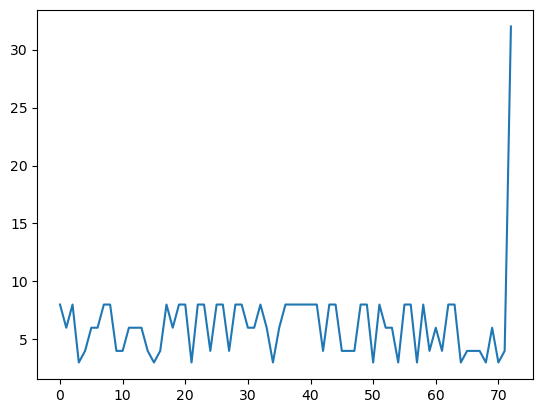

In [562]:
fig = plt.figure()
plt.plot(np.arange(len(filtered_info[idx][2])), filtered_info[idx][2])

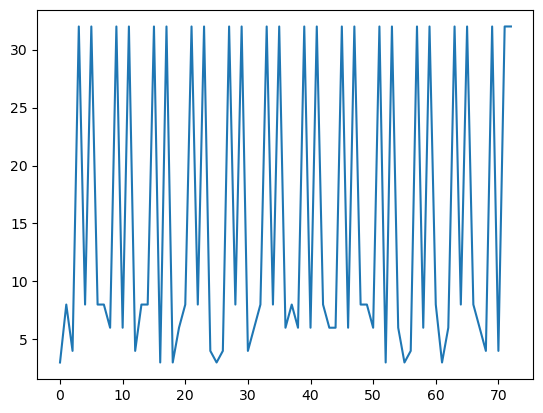

In [563]:
plt.plot(np.arange(len(filtered_info[idx][3])), filtered_info[idx][3])

In [564]:
# used for generating random bit configs
filtered_info = []
for bps, fit, wconf, aconf in zip(bops_acc, fit_values_acc, w_configs_acc, a_configs_acc):
    filtered_info.append((bps, fit, wconf, aconf))
idx = np.random.choice(len(w_configs_acc),1)[0]
print(filtered_info[idx])
criterion = (filtered_info[idx][0], filtered_info[idx][1])

(34169738584.25, 1.1217018407569623, [3, 6, 3, 6, 6, 3, 4, 6, 6, 8, 8, 8, 6, 6, 3, 6, 8, 8, 6, 6, 8, 8, 6, 6, 8, 3, 8, 6, 8, 6, 6, 6, 6, 6, 3, 8, 6, 6, 6, 3, 6, 6, 6, 8, 3, 3, 8, 6, 8, 6, 6, 3, 8, 6, 6, 6, 8, 3, 6, 6, 6, 6, 4, 6, 6, 6, 6, 3, 6, 6, 6, 6, 32], [3, 8, 8, 32, 6, 32, 4, 6, 3, 32, 6, 32, 6, 4, 8, 32, 8, 32, 6, 4, 4, 32, 3, 32, 4, 6, 3, 32, 4, 32, 3, 3, 8, 32, 8, 32, 6, 6, 6, 32, 6, 32, 6, 4, 8, 32, 8, 32, 8, 6, 4, 32, 4, 32, 3, 3, 8, 32, 3, 32, 6, 6, 3, 32, 6, 32, 6, 4, 3, 32, 6, 32, 32])


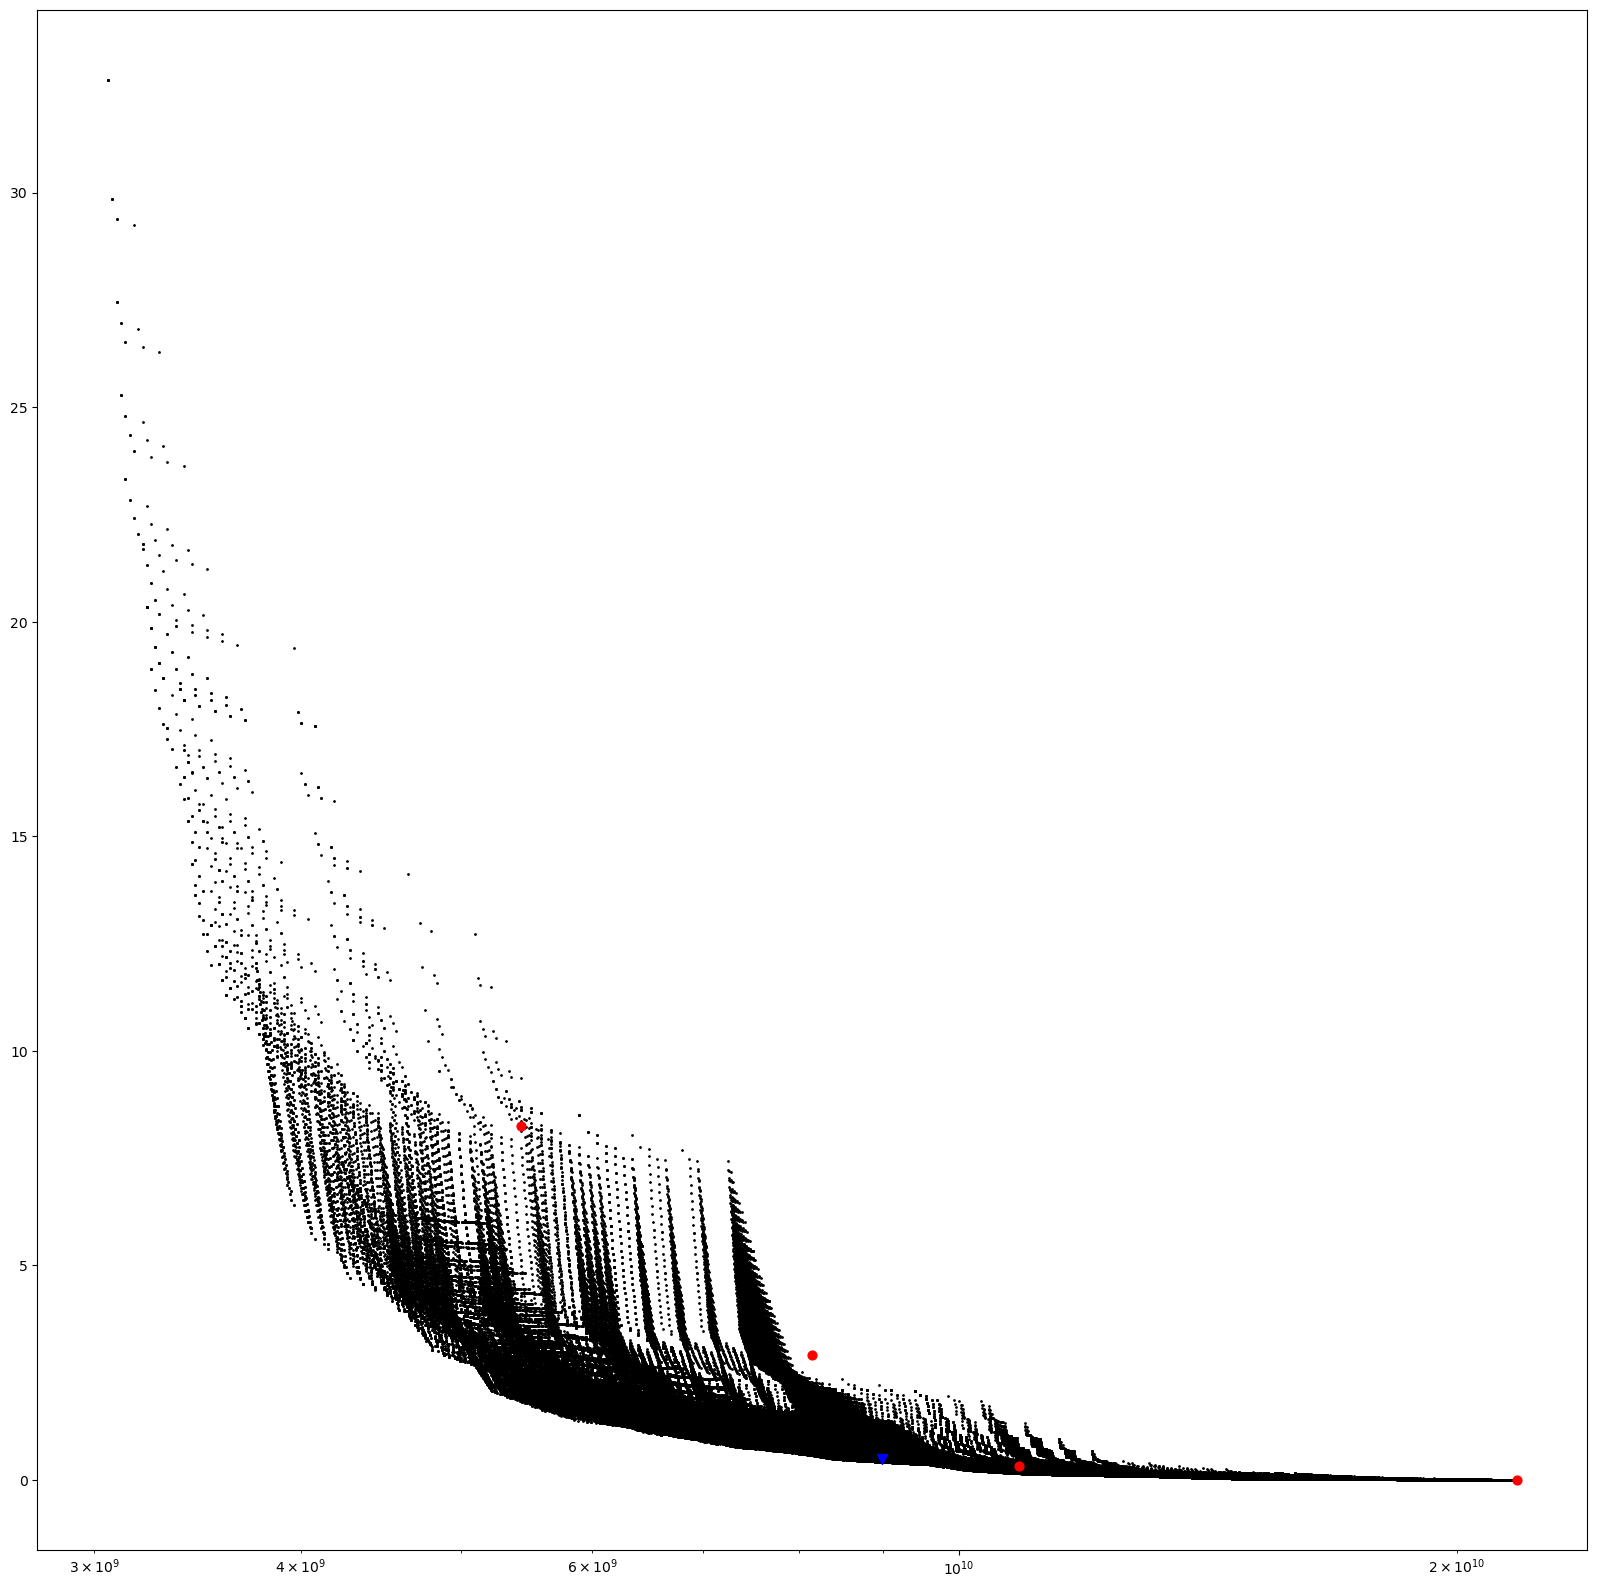

In [783]:
fig = plt.figure(figsize=(20,20))
# plt.scatter(bops_acc, fit_values_acc, s=1,)

plt.xscale('log')
plt.scatter(ordered_bops_acc, ordered_fit_values_acc, c='black', s=1)
plt.scatter(hbops_acc, hfit_values_acc, s=40,c='red')
plt.scatter(filtered_info[idx][0], filtered_info[idx][1], s=50, marker='v', c='blue')


In [799]:
# used for generating optimal bit configs
criterion = 0.8e10
filtered = []
filtered_info = []
for bps, fit, wconf, aconf in zip(ordered_bops_acc, ordered_fit_values_acc, ordered_w_configs_acc, ordered_a_configs_acc):
    if 3 in wconf:
        continue
    if bps < criterion:
        filtered.append(fit)
        filtered_info.append((bps, fit, wconf, aconf))
idx = np.argmin(filtered)
print(filtered_info[idx])

(7927285190.0, 0.7091949001566606, [2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 8, 2, 2, 2, 2, 4, 8, 2, 2, 2, 2, 4, 8, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 32], [4, 4, 4, 8, 8, 8, 4, 4, 4, 8, 8, 8, 4, 4, 4, 8, 8, 8, 4, 4, 4, 8, 8, 8, 4, 4, 4, 8, 8, 8, 4, 4, 4, 8, 8, 8, 4, 4, 4, 8, 8, 8, 4, 4, 4, 8, 8, 8, 4, 4, 4, 8, 8, 8, 4, 4, 4, 8, 4, 8, 4, 4, 4, 8, 4, 8, 4, 4, 4, 8, 4, 8, 32])


In [826]:
layer_bits = {}
for l, b in zip(names[:-1], highlight_configs[-1]):
    layer_bits[l[13:]] = int(b)
    
activation_bits = {}
for l, b in zip(names[:-1], ac):
    if 'output' in l:
        continue
    activation_bits[l[13:]] = int(b)
    
criterion = '4/2-paper'

In [819]:
layer_bits = {}
for l, b in zip(names[:-1], filtered_info[idx][2]):
    layer_bits[l[13:]] = int(b)

In [820]:
activation_bits = {}
for l, b in zip(names[:-1], filtered_info[idx][3]):
    if 'output' in l:
        continue
    activation_bits[l[13:]] = int(b)

In [827]:
print(layer_bits)

{'layer.0.attention.self.query': 2, 'layer.0.attention.self.key': 2, 'layer.0.attention.self.value': 2, 'layer.0.attention.output.dense': 2, 'layer.0.intermediate.dense': 2, 'layer.0.output.dense': 4, 'layer.1.attention.self.query': 2, 'layer.1.attention.self.key': 2, 'layer.1.attention.self.value': 2, 'layer.1.attention.output.dense': 2, 'layer.1.intermediate.dense': 4, 'layer.1.output.dense': 4, 'layer.2.attention.self.query': 2, 'layer.2.attention.self.key': 2, 'layer.2.attention.self.value': 2, 'layer.2.attention.output.dense': 2, 'layer.2.intermediate.dense': 4, 'layer.2.output.dense': 4, 'layer.3.attention.self.query': 2, 'layer.3.attention.self.key': 2, 'layer.3.attention.self.value': 2, 'layer.3.attention.output.dense': 2, 'layer.3.intermediate.dense': 4, 'layer.3.output.dense': 4, 'layer.4.attention.self.query': 2, 'layer.4.attention.self.key': 2, 'layer.4.attention.self.value': 2, 'layer.4.attention.output.dense': 2, 'layer.4.intermediate.dense': 4, 'layer.4.output.dense': 4,

In [828]:
print(activation_bits)

{'layer.0.attention.self.query': 8, 'layer.0.attention.self.key': 8, 'layer.0.attention.self.value': 8, 'layer.0.intermediate.dense': 8, 'layer.1.attention.self.query': 8, 'layer.1.attention.self.key': 8, 'layer.1.attention.self.value': 8, 'layer.1.intermediate.dense': 8, 'layer.2.attention.self.query': 8, 'layer.2.attention.self.key': 8, 'layer.2.attention.self.value': 8, 'layer.2.intermediate.dense': 8, 'layer.3.attention.self.query': 8, 'layer.3.attention.self.key': 8, 'layer.3.attention.self.value': 8, 'layer.3.intermediate.dense': 8, 'layer.4.attention.self.query': 8, 'layer.4.attention.self.key': 8, 'layer.4.attention.self.value': 8, 'layer.4.intermediate.dense': 8, 'layer.5.attention.self.query': 8, 'layer.5.attention.self.key': 8, 'layer.5.attention.self.value': 8, 'layer.5.intermediate.dense': 8, 'layer.6.attention.self.query': 8, 'layer.6.attention.self.key': 8, 'layer.6.attention.self.value': 8, 'layer.6.intermediate.dense': 8, 'layer.7.attention.self.query': 8, 'layer.7.att

In [829]:
import json
import os
# criterion = (filtered_info[idx][0], filtered_info[idx][1])
criterion = '42-testing'
filename = '/home/ben/Documents/CERN/rebuttal_iclr/test_configs/45000000000.0.json'
new_filename = f'/home/ben/Documents/CERN/rebuttal_iclr/optimal_configs/{criterion}.json'
with open(filename, 'r') as f:
    data = json.load(f)
    data['layer_bits'] = layer_bits
    data['activation_bits'] = activation_bits

with open(new_filename, 'w') as fn:
    json.dump(data, fn, indent=4)

In [830]:
### analyse the results
# put all configs in a general directory

In [30]:
file_acc_dict = {
    '16000000000.0.json':0.8279816514,
    '17000000000.0.json':0.8153669725,
    '18000000000.0.json':0.8314220183,
    '19000000000.0.json':0.8405963303,
    '20000000000.0.json':0.8279816514,
    '21000000000.0.json':0.8302752294,
    '22000000000.0.json':0.8428899083,
    '23000000000.0.json':0.8348623853,
    '24000000000.0.json':0.8589449541,
    '25000000000.0.json':0.8543577982,
    '26000000000.0.json':0.8887614679,
    '27000000000.0.json':0.8394495413,
    '28000000000.0.json':0.8979357798,
    '29000000000.0.json':0.8864678899,
    '30000000000.0.json':0.8944954128,
    '35000000000.0.json':0.9266055046,
    '40000000000.0.json':0.9151376147,
    '45000000000.0.json':0.9208715596,
    '(37994158472.0, 2.1125307690449087).json':0.8543577982,
    '(38734976859.5, 2.9152579391321956).json':0.8555045872,
    '(39225710943.5, 0.6412828853874644).json':0.9002293578,
    '(40929122405.0, 3.339522149490144).json':0.8233944954,
    '(44604906741.5, 0.1144469573289058).json':0.9323394495,
    '(32180851928.0, 1.5903266288292397).json':0.8371559633,
    '(32237474330.0, 4.038185281731267).json':0.8142201835,
    '(32548902221.0, 2.319405301281723).json':0.8532110092,
    '(32629118238.5, 2.4071521977904022).json':0.8394495413,
    '(33242535177.5, 0.6682451251139252).json':0.8967889908,
    '(33912574878.5, 2.3991565054512423).json':0.8371559633,
    '(34938869324.75, 1.918026896908218).json':0.8371559633,
    '(35214907188.5, 0.5678332030212314).json':0.879587156,
    '(36762605424.5, 1.6341288573385588).json':0.8428899083,
    '(37137733535.75, 1.0185334741883005).json':0.872706422,
    '(18883857101.0, 1.030592653595437).json':0.8279816514,
    '(24933092816.0, 0.20048264420447667).json':0.8360091743,
    '(25999494875.0, 0.15804899107343373).json':0.8910550459,
    '(11966400902.0, 0.1314613128557236).json':0.9094036697,
    '(14835305462.0, 0.034714298367532495).json':0.9151376147,
    '(5898290201.0, 1.625665134475337).json':0.8107798165,
    '(2, 2).json':0.8474770642,
    '(21250231597.25, 4.389752352399446).json':0.8348623853,
    '(22819163576.0, 3.8806863843514288).json':0.8268348624,
    '(22915895174.75, 1.708298323708937).json':0.8669724771,
    '(23253274106.0, 4.21751588419633).json':0.8279816514,
    '(24598073109.5, 4.117369457870098).json':0.8291284404,
    '(25931075125.25, 4.334070172429961).json':0.8268348624,
    '(26674253961.5, 2.176084654181423).json':0.8314220183,
    '(29156233638.5, 1.8027137898131922).json':0.8188073394,
    '(31189946933.0, 4.096568014037123).json':0.8222477064,
}

In [31]:
print(len(file_acc_dict))

49


In [36]:
import json

In [32]:
base_path = '/home/ben/Documents/CERN/rebuttal_iclr/total_configs/'

In [88]:
FIT_values = []
Accuracies = []
for k in file_acc_dict:
    layer_dict = None
    act_dict = None
    with open(f'{base_path}{k}', 'r') as f:
        data = json.load(f)
        layer_dict = data['layer_bits']
        act_dict = data['activation_bits']
#     print(len(layer_dict))
#     print(len(act_dict))
#     print(len(names))
    w_config = []
    a_config = []
    repr_a_config = []
    for n in names[:-1]:
        if n[13:] in layer_dict:
            w_config.append(layer_dict[n[13:]])
        if n[13:] in act_dict:
            a_config.append(act_dict[n[13:]])
            repr_a_config.append(act_dict[n[13:]])
        else:
            a_config.append(32)
    w_config.append(32)
    a_config.append(32)
#     print(len(w_config))
#     print(len(a_config))
    fit_value = fit_computerw.FIT(np.array(w_config), np.array(a_config))
    FIT_values.append(fit_value)
    Accuracies.append(file_acc_dict[k])
    print(k)
    print(w_config)
    print(repr_a_config)
    print(file_acc_dict[k])
    print('')

16000000000.0.json
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 32]
[4, 4, 4, 4, 3, 3, 4, 4, 3, 4, 3, 3, 6, 4, 3, 4, 3, 3, 4, 4, 3, 3, 4, 6, 3, 4, 4, 4, 6, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 6, 3, 4, 4, 4, 3, 3, 3]
0.8279816514

17000000000.0.json
[3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 6, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 32]
[8, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]
0.8153669725

18000000000.0.json
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,

In [89]:
ac = [8 for i in range(73)]
highlight_configs = []
highlight_configs.append([4 for i in range(73)])

accuracy_his = [0.8566513761]
# highlight_configs.append([2 for i in range(73)])
for wc, acc in zip(highlight_configs, accuracy_his):
#     ac[0] = 8
    wc[-1] = 32
    ac[-1] = 32
    ac = set_act_bits(names, ac)
    fit_value = fit_computerw.FIT(np.array(wc), np.array(ac))

    FIT_values.append(fit_value)
    Accuracies.append(acc)

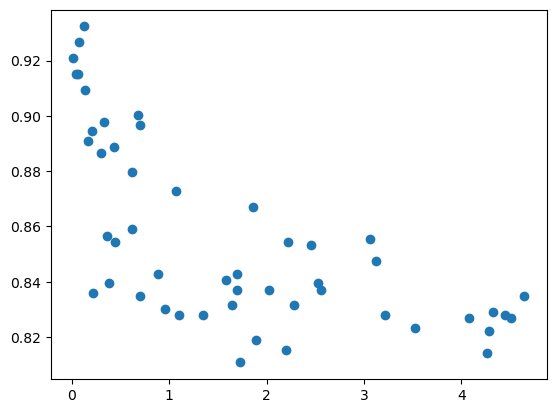

In [90]:
fig = plt.figure()
plt.scatter(FIT_values, Accuracies)
    

In [91]:
from scipy.stats import spearmanr

In [92]:
print(spearmanr(FIT_values, Accuracies))

SpearmanrResult(correlation=-0.7523121858521375, pvalue=2.996496101675727e-10)
